In [36]:
import dynesty
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import welch

# import the PyCBC package
import pycbc.waveform
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal as _lal


In [37]:
# define the inner product
def inner_product(h1, h2, Sn, df):
    """Calculate the inner product of two waveforms h1 and h2."""
    return np.abs(np.sum(np.conj(h1) * h2 / Sn)) * df

# define a function that calculates the SNR:
def SNR(a, b, Sn, frequency_spacing):
    """
    Calculate the SNR of a signal a in the presence of noise b.

    SNR = sqrt(4 * <a|b>), where <a|b> is the inner product of a and b and the noise power spectrum Sn.

    Parameters
    ----------
    a : array_like
        The signal template
    b : array_like
        The noisy data
    Sn : array_like
        The noise power spectrum
    frequency_spacing : float
        The frequency spacing of the data

    Returns
    -------
    float
        The signal-to-noise ratio of the signal a in the noisy data b
    """
    # 
    inner = inner_product(a, b, Sn, frequency_spacing)
    return np.sqrt(inner * 4)

In [38]:
end_of_signal = 171.828125
signal_duraton = 8.0

In [39]:
# define the F_plus and F_cross functions
def F(theta,phi,psi,polarisation = "plus"):
    if polarisation == "plus":
        return (1+np.cos(theta)**2)/2 * np.cos(2*phi) * np.cos(2*psi) + np.cos(theta) * np.sin(2*phi) * np.sin(2*psi)
    else:
        return (1+np.cos(theta)**2)/2 * np.cos(2*phi) * np.sin(2*psi) - np.cos(theta) * np.sin(2*phi) * np.cos(2*psi)


In [40]:
# defien a waveform model
def waveform_model(params: dict[str, float],
                   frequency_array: np.array) -> tuple[np.array, np.array]:
    """
    A wrapper function that takes a list of BBH parameters and returns teo frequency arrays and the frequency-domain waveform
    """
    
    # unpack the parameters
    m1 = params["mass1"]
    m2 = params["mass2"]
    chi1 = params["spin1"]
    chi2 = params["spin2"]
    DL = params["luminositydistance"]
    iota = params["inclination"]
    phi_ref = params["phase"]

    m1, m2

    # define the frequency array
    f_lower = frequency_array[0]
    f_final = frequency_array[-1]
    
    # define the waveform model
    hp, hc = pycbc.waveform.get_fd_waveform(approximant="IMRPhenomD",
                                            mass1=m1,
                                            mass2=m2,
                                            spin1z=chi1,
                                            spin2z=chi2,
                                            distance=DL,
                                            inclination=iota,
                                            coa_phase=phi_ref,
                                            f_lower=f_lower,
                                            delta_f=frequency_array[1]-frequency_array[0])
    
    return (hp, hc)


In [41]:
# define the frequency array
f_lower = 10
f_upper = 1024
delta_f = 1.0/16
frequency_array = np.arange(f_lower, f_upper, delta_f)

# initial the parameters
initial_params = {"mass1": 30.0,
                    "mass2": 30.0,
                    "spin1": 0.0,
                    "spin2": 0.0,
                    "luminositydistance": 600.0,
                    "inclination": np.pi/3,
                    "phase": 0.0,
                    "theta": 0.0,
                    "phi": 0.0,
                    "psi": 0.0}




In [42]:
# read the expected PSD
ASD_expected = np.loadtxt('Coursework_Data/ASD.txt')
ASD_expected_freq = ASD_expected[:,0]
ASD_expected_value = ASD_expected[:,1]
PSD_expected_value = ASD_expected_value**2

# interpolate the PSD to the frequency array
PSD_expected_value = interpolate.interp1d(ASD_expected_freq, PSD_expected_value, kind='linear')(frequency_array)

In [43]:
# read testdata 
data = np.loadtxt('Coursework_Data/data.txt')
data_value = data[:,1]
data_time = data[:,0]

# get the sampling rate 
sampling_rate = 1/(data_time[1] - data_time[0])

# copy the original data
data_value_orginal = data_value.copy()

# filter the data such that it centered around the signal with the appropriate duration
t_end = end_of_signal + signal_duraton/2
t_start = t_end - signal_duraton
data_value = data_value[(data_time >= t_start) & (data_time <= t_end)]
data_time = data_time[(data_time >= t_start) & (data_time <= t_end)]

# shif the time domain data by 
data_time = data_time - end_of_signal

In [44]:
# frequency array for the data
delta_f = 1/16
f_array = np.linspace(f_lower, f_upper, int((f_upper - f_lower)/delta_f))

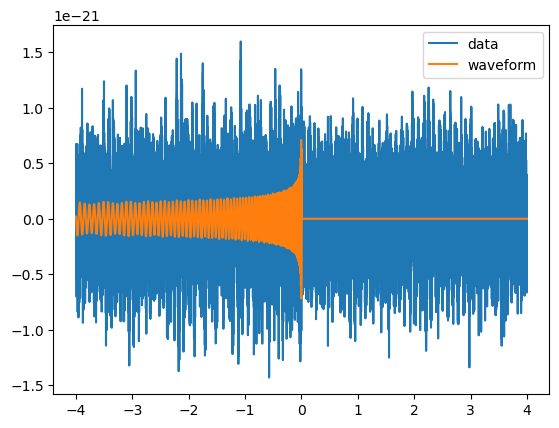

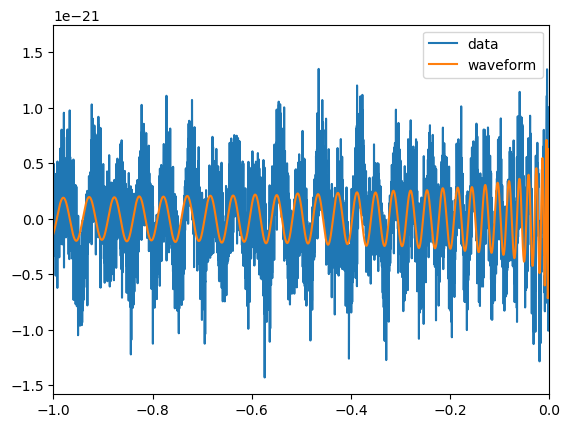

In [45]:
# generate the waveform
hp, hc = waveform_model(initial_params, frequency_array)

# get time series data 
hp_time = hp.to_timeseries()
hc_time = hc.to_timeseries()

# h = hp * F_plus + hc * F_cross
h = hp_time * F(initial_params["theta"], initial_params["phi"], initial_params["psi"], "plus") + hc_time * F(initial_params["theta"], initial_params["phi"], initial_params["psi"], "cross")

# get the frequency array of the waveform
h_freq = hp.sample_frequencies

# cut the waveform to the same length as the data   
h = h[(hp_time.sample_times >= -4)]
h_time = hp_time.sample_times
h_time = h_time[(hp_time.sample_times >= -4)]

# fill in the zeros at the end of the waveform
zero_value = np.zeros(len(data_time) - len(h_time))
zero_time = np.linspace(h_time[-1], data_time[-1], len(zero_value))

h = np.concatenate((h, zero_value))
h_time = np.concatenate((h_time, zero_time))

# plot h and data
plt.figure()
plt.plot(data_time, data_value, label="data")
plt.plot(h_time, h, label="waveform")
plt.legend()
plt.show()

# plot the data from -1 to 0s 
plt.figure()
plt.plot(data_time, data_value, label="data")
plt.plot(h_time, h, label="waveform")
plt.xlim(-1, 0)
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


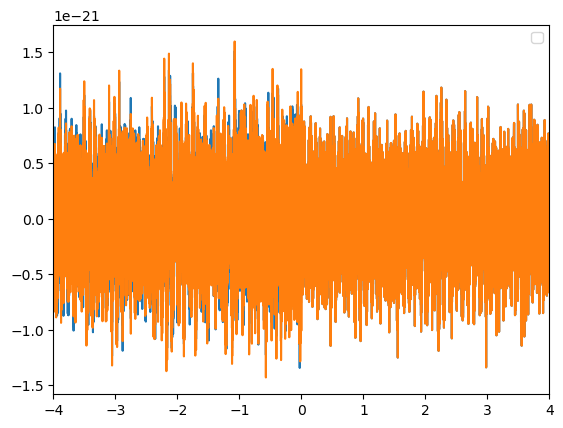

In [46]:
# interpolate the data to the time domain of the template
h_interpolate = interpolate.interp1d(h_time, h, kind='linear', fill_value='extrapolate')(data_time)
residual_time = data_value - h_interpolate

# plot the residual
plt.figure()
plt.plot(data_time, residual_time)
plt.plot(data_time, data_value)
plt.xlim(-4, 4)
plt.legend()
plt.show()

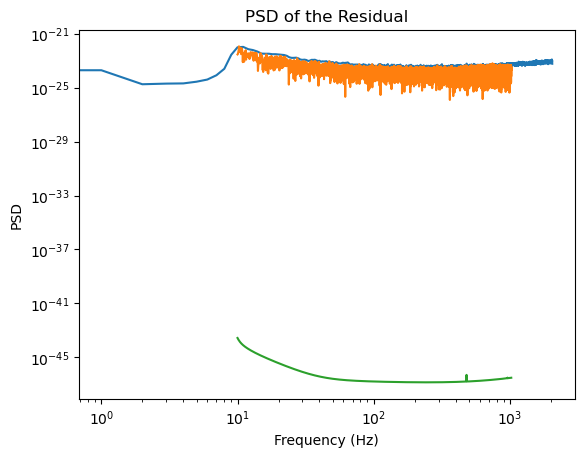

26.94051962833089 1.41234401177537e-06


In [47]:
# use welch to calculate the fourier transform of the residual
residual_data_freq, residual_fft = welch(residual_time, fs=1/(data_time[1] - data_time[0]), nperseg=4*1024)
residual_fft = np.sqrt(residual_fft)
plt.figure()
plt.loglog(residual_data_freq, residual_fft, label='Residual1')

# direct fourier transform the residual
residual_fft = np.fft.fft(residual_time)
residual_data_freq = np.fft.fftfreq(len(residual_time), d=data_time[1] - data_time[0])
# interpolate the PSD of the residual to the frequency array
residual_fft = interpolate.interp1d(residual_data_freq, residual_fft, kind='linear', fill_value='extrapolate')(f_array)
# normalize the residual_fft
residual_fft = residual_fft / np.sqrt(2 * len(data_time)) / np.sqrt(sampling_rate)

# plot the PSD of the residual
plt.loglog(f_array, np.abs(residual_fft), label='Residual')
plt.loglog(f_array, PSD_expected_value, label='Expected PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('PSD of the Residual')
plt.show()

SNR_residual = SNR(residual_fft, residual_fft, PSD_expected_value, delta_f)
likelihood = np.exp(-0.5 * SNR_residual)
print (SNR_residual, likelihood)

In [48]:
initial_params["mass1"] = 30.0
initial_params["mass2"] = 10.0
initial_params["spin1"] = 0.0
initial_params["spin2"] = 0.0

447736.74372671166 0.0


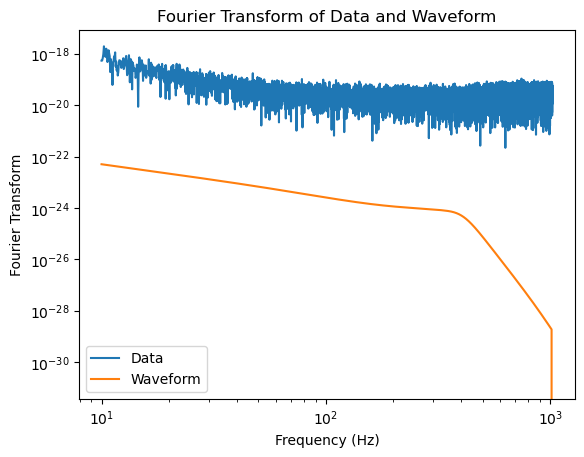

In [49]:
# direct fourier transform the data 
data_fft = np.fft.fft(data_value)
data_freq = np.fft.fftfreq(len(data_time), d=data_time[1] - data_time[0])
sampling_rate = 1/(data_time[1] - data_time[0])
# normalize the data_fft
# data_fft = data_fft / np.sqrt(len(data_time)) / np.sqrt(sampling_rate)
# interpolate the PSD of the data to the frequency array
data_fft = interpolate.interp1d(data_freq, data_fft, kind='linear', fill_value='extrapolate')(f_array)

# generate the waveform
hp, hc = waveform_model(initial_params, frequency_array)
h_freq = hp.sample_frequencies
# interpolate the waveform to the frequency array
hp = interpolate.interp1d(h_freq, hp, kind='linear', fill_value='extrapolate')(f_array)

residual = data_fft - hp
SNR_residual = SNR(residual, residual, PSD_expected_value, delta_f)
likelihood = np.exp(-0.5 * SNR_residual)
print (SNR_residual, likelihood)

# plot data_fft and h
plt.figure()
plt.loglog(f_array, np.abs(data_fft), label='Data')
plt.loglog(f_array, np.abs(hp), label='Waveform')
# plt.loglog(f_array, np.abs(residual), label='Residual')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Fourier Transform')
plt.title('Fourier Transform of Data and Waveform')
plt.legend()
plt.show()

In [50]:
# define the likelihood function
def likelihood(params: list[float],
                ) -> float:
    """
    A function that takes a list of BBH parameters and returns the log-likelihood of the data given the model
    """

    # pack the parameters
    params = {"mass1": params[0],
                "mass2": params[1],
                "spin1": params[2],
                "spin2": params[3],
                "luminositydistance": params[4],
                "inclination": params[5],
                "phase": params[6],
                "theta": params[7],
                "phi": params[8],
                "psi": params[9]}

    
    # generate the waveform
    hp, hc = waveform_model(params, frequency_array)

    # get time series data 
    hp_time = hp.to_timeseries()
    hc_time = hc.to_timeseries()

    # h = hp * F_plus + hc * F_cross
    h = hp_time * F(initial_params["theta"], initial_params["phi"], initial_params["psi"], "plus") + hc_time * F(initial_params["theta"], initial_params["phi"], initial_params["psi"], "cross")

    # cut the waveform to the same length as the data   
    h = h[(hp_time.sample_times >= -4)]
    h_time = hp_time.sample_times
    h_time = h_time[(hp_time.sample_times >= -4)]

    # fill in the zeros at the end of the waveform
    zero_value = np.zeros(len(data_time) - len(h_time))
    zero_time = np.linspace(h_time[-1], data_time[-1], len(zero_value))

    h = np.concatenate((h, zero_value))
    h_time = np.concatenate((h_time, zero_time))


    # interpolate the data to the time domain of the template
    h_interpolate = interpolate.interp1d(h_time, h, kind='linear', fill_value='extrapolate')(data_time)
    residual_time = data_value - h_interpolate

    # use welch to calculate the fourier transform of the residual
    residual_data_freq, residual_fft = welch(residual_time, fs=1/(data_time[1] - data_time[0]), nperseg=4*1024)
    residual_fft = np.sqrt(residual_fft)
    
    # interpolate the PSD of the residual to the frequency array
    residual_fft = interpolate.interp1d(residual_data_freq, residual_fft, kind='linear', fill_value='extrapolate')(f_array)

    # direct fourier transform the residual
    # residual_fft = np.fft.fft(residual_time)
    # residual_data_freq = np.fft.fftfreq(len(residual_time), d=data_time[1] - data_time[0])
    # # interpolate the PSD of the residual to the frequency array
    # residual_fft = interpolate.interp1d(residual_data_freq, residual_fft, kind='linear', fill_value='extrapolate')(f_array)
    # # normalize the residual_fft
    # residual_fft = residual_fft / np.sqrt(2 * len(data_time)) / np.sqrt(sampling_rate)
    
    # calculate the SNR of the residual
    SNR_residual = SNR(residual_fft, residual_fft, PSD_expected_value, delta_f)
    likelihood = np.exp(-0.5 * SNR_residual)

    return likelihood



In [51]:
# prior transform function that is compatible with dynesty
def prior_transform(u):
    """
    A function that maps a unit cube to the parameter space
    """
    
    # define the parameter as a list of parameters
    params = {}
    params["mass1"] = 25 + 10*u[0]
    params["mass2"] = 25 + 10*u[1]
    params["spin1"] = -0.99 + 0.99*u[2]
    params["spin2"] = -0.99 + 0.99*u[3]
    params["luminositydistance"] = 500 + 100*u[4]
    params["inclination"] = np.arccos(2*u[5] - 1)
    params["phase"] = 2*np.pi*u[6]
    params["theta"] = np.arccos(2*u[7] - 1)
    params["phi"] = 2*np.pi*u[8]
    params["psi"] = 2*np.pi*u[9]

    # conver to a list
    params = list(params.values())

    return params

In [52]:
# use dynesty to sample the posterior

# initialize the sampler
sampler = dynesty.NestedSampler(likelihood, prior_transform, ndim=10, nlive=1000)


Exception while calling loglikelihood function:
  params: [ 2.71603220e+01  3.21660169e+01 -2.04357376e-01 -4.77715287e-01
  5.48291756e+02  2.08933524e+00  6.05631643e+00  1.76749927e+00
  1.89449275e+00  3.80734303e+00]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/zhongjunbao/miniconda3/envs/04_Gravitational_Wave/lib/python3.11/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_92516/1688193767.py", line 34, in likelihood
    h_time = h_time[(hp_time.sample_times >= -4)]
                     ^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhongjunbao/miniconda3/envs/04_Gravitational_Wave/lib/python3.11/site-packages/pycbc/types/timeseries.py", line 239, in get_sample_times
    return Array(range(len(self))) * self._delta_t + float(self._epoch)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhongjunbao/miniconda3/envs/04_Gravitational_Wave/lib/python3.11/site-packages/pycbc/types/array.py", line 182, in __init__
    initial_array = _numpy.array(initial_array)
                    ^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
# run the sampler
sampler.run_nested()

# get the results
results = sampler.results

1it [00:01,  1.39s/it, +10000 | bound: 0 | nc: 1 | ncall: 20001 | eff(%): 100.000 | loglstar:   -inf <  0.000 <    inf | logz: -0.000 +/-    nan | dlogz:  0.000 > 10.009]


In [ ]:
import dynesty.plotting as dyplot

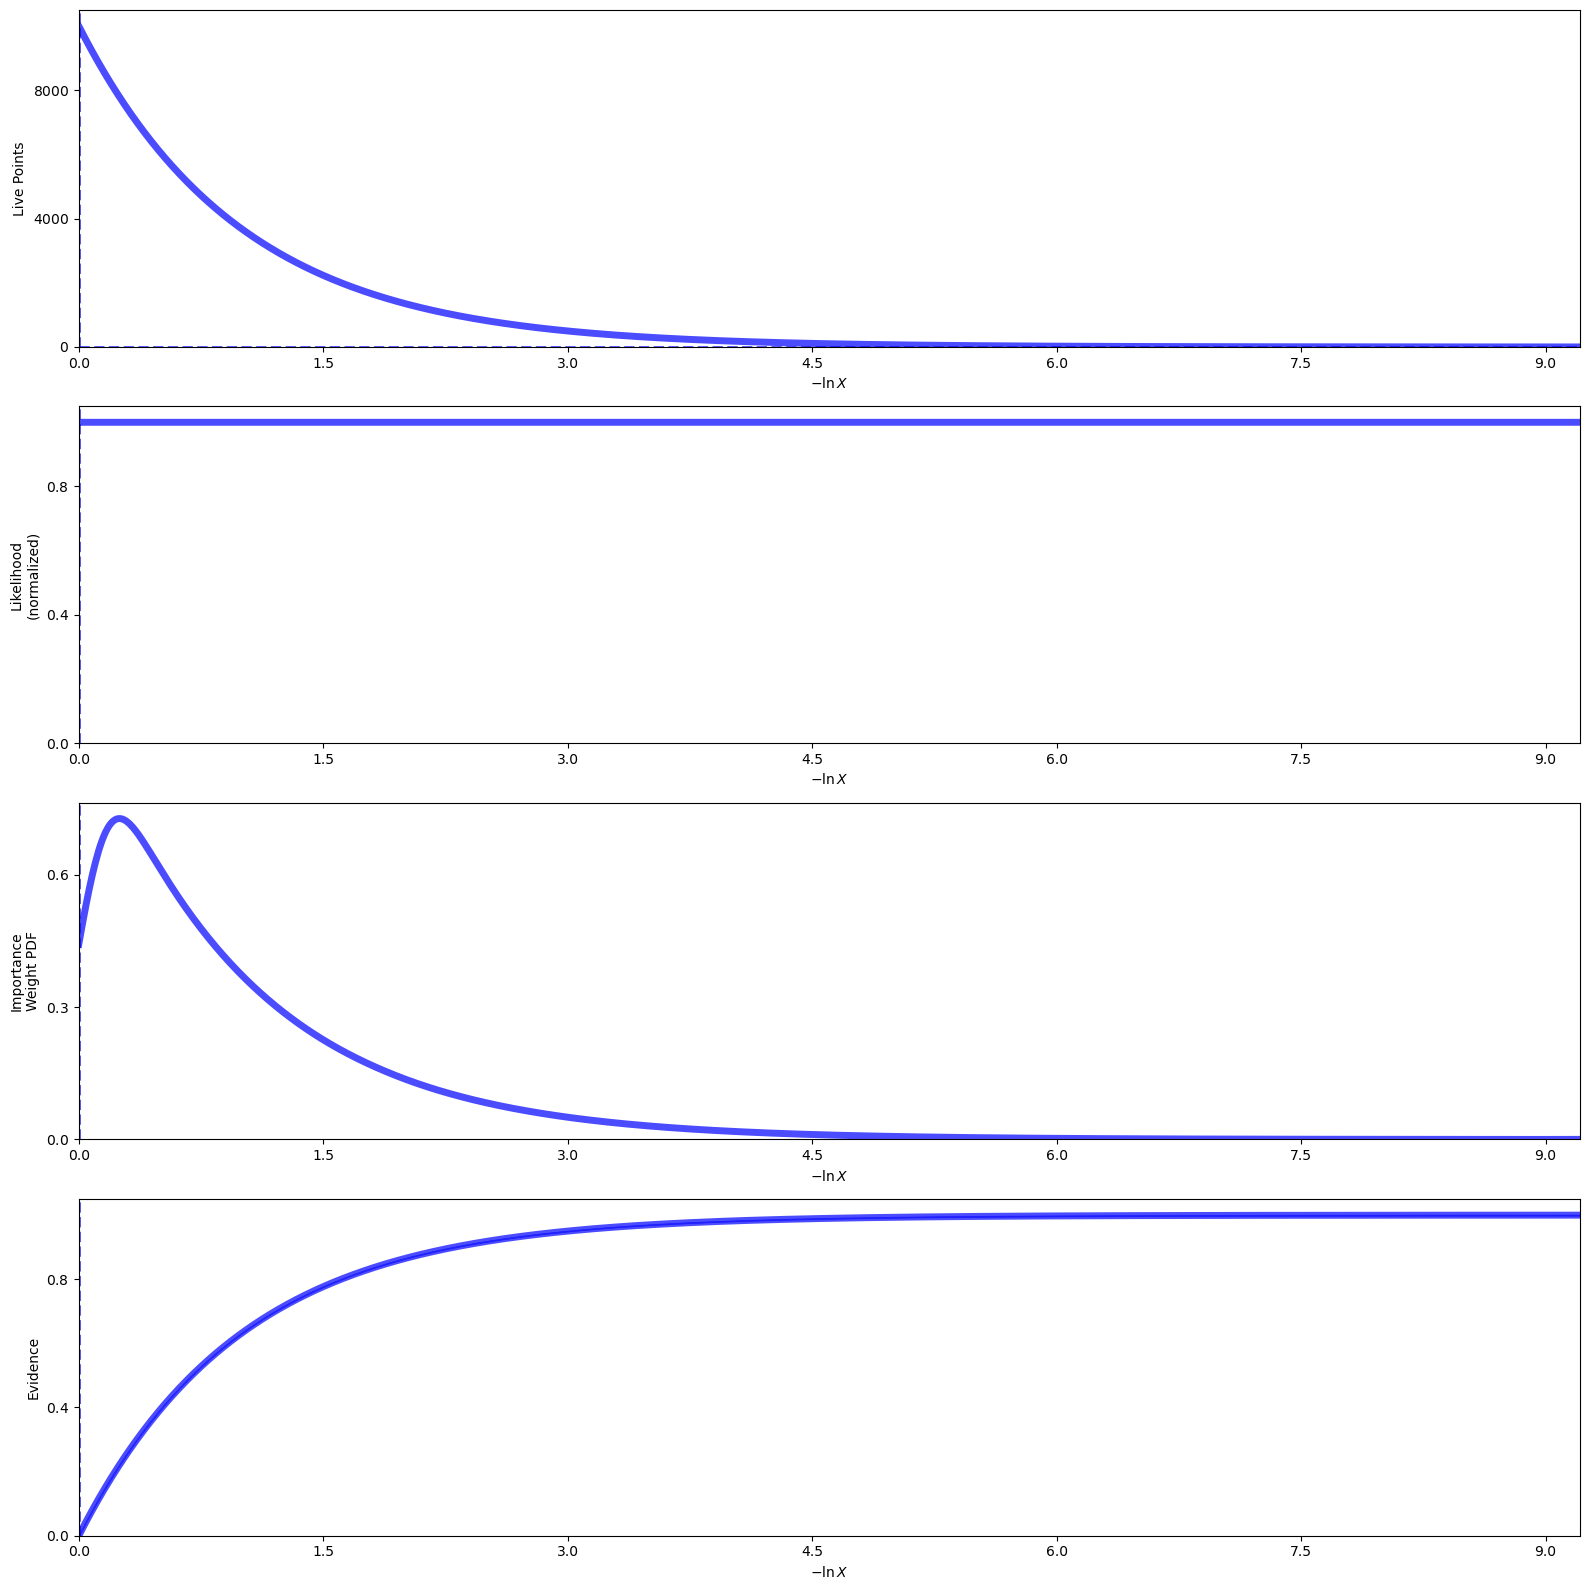

In [ ]:
# visualize the results
fig, axes = dyplot.runplot(results)
fig.tight_layout()
plt.show()


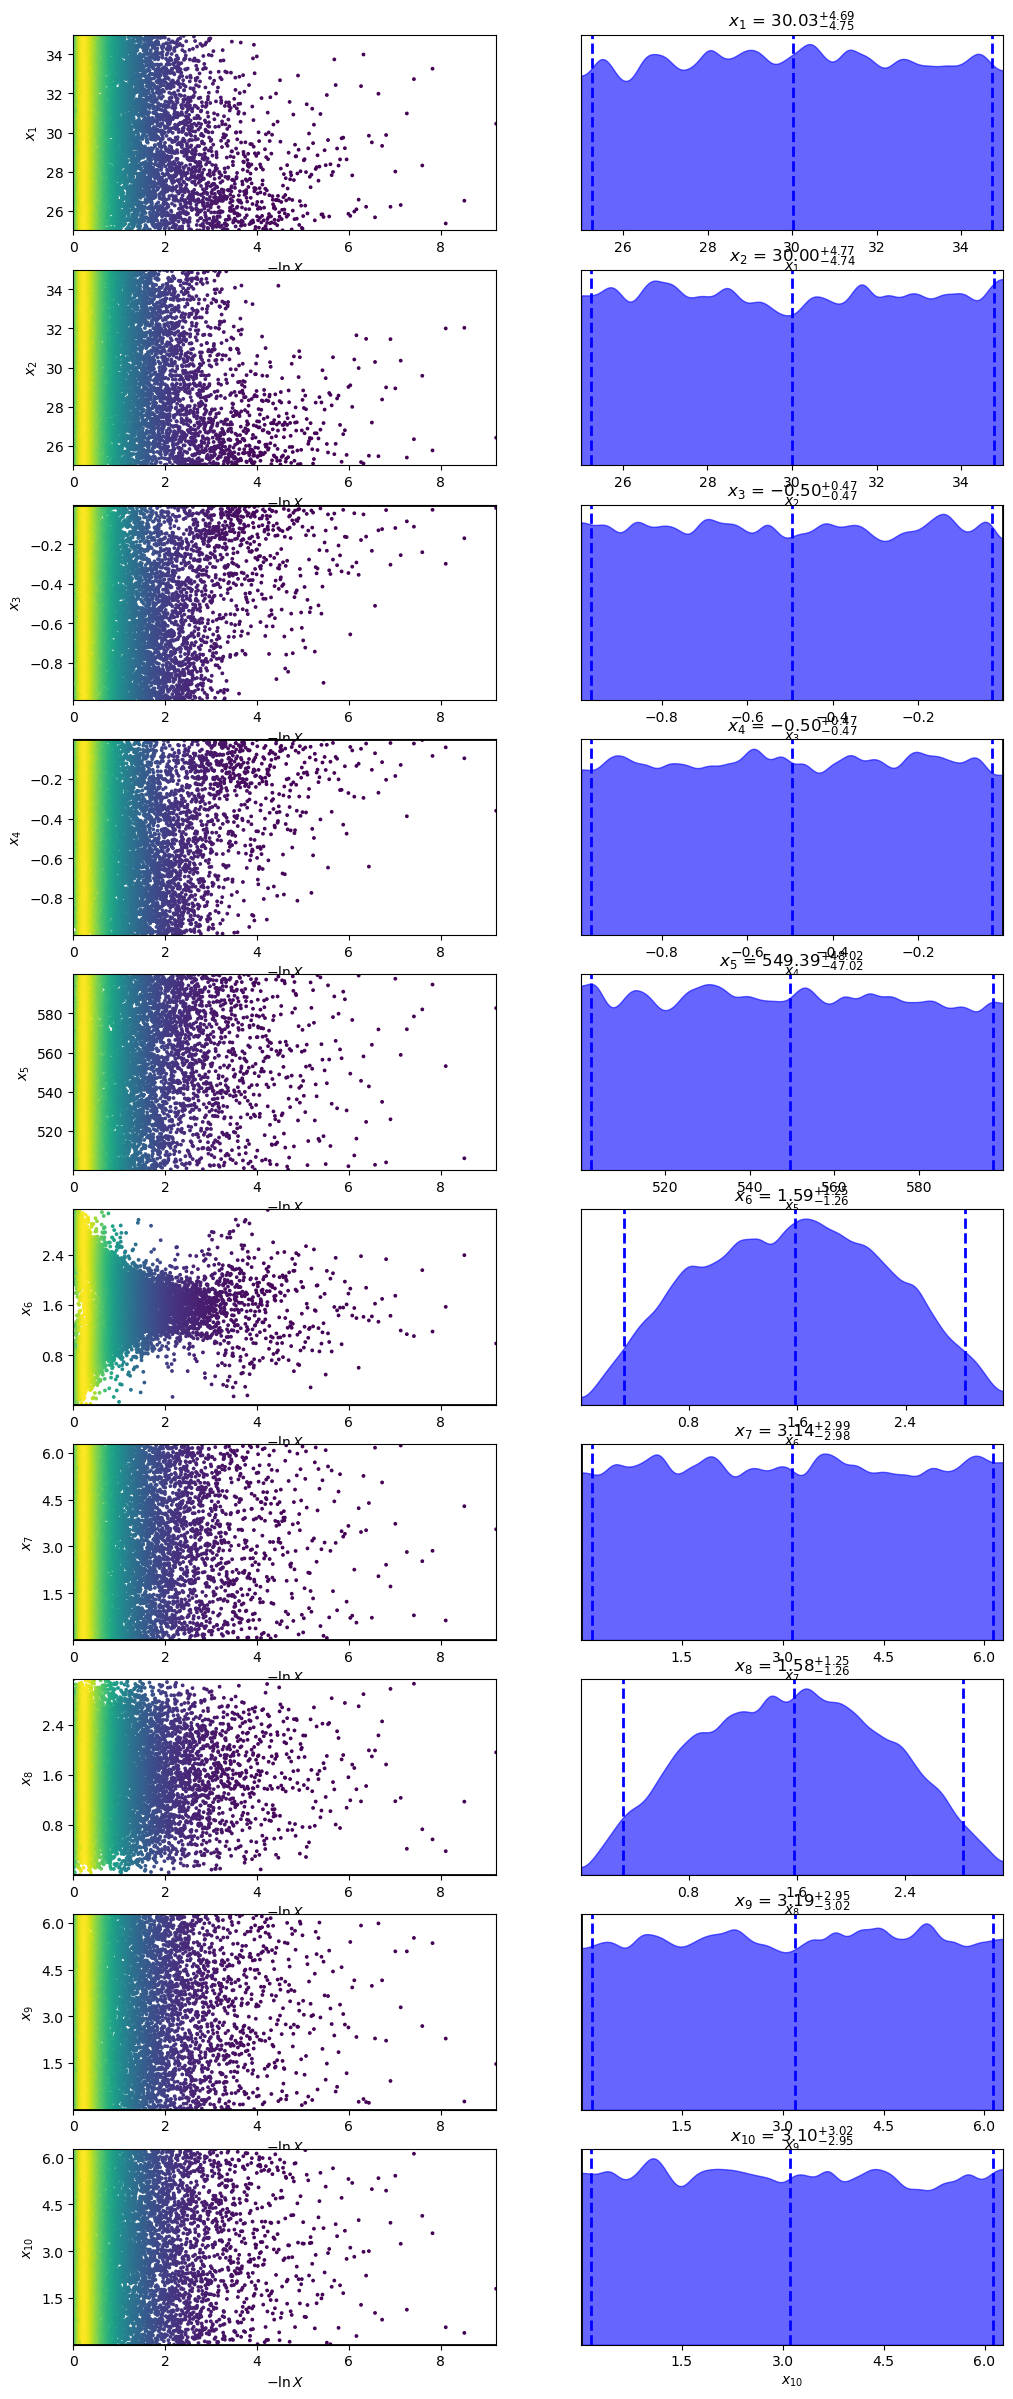

In [ ]:
fig, axes = dyplot.traceplot(results, truths=np.zeros(10),
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(5))